<a href="https://colab.research.google.com/github/mengmeng-bot/CS230-Project-Fine-Tuning-BERT-on-Fine-Foods/blob/main/train_with_new_dataset_2nd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = 'drive/My Drive/Colab Notebooks/'
data_path = path+'omen_dataset_updated_2char.csv'

Mounted at /content/drive


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv(data_path)

# 2. Count how many entries each label (category) has for narrative_function
print("Entries per narrative_function label:")
print(df["narrative_function"].value_counts())

print("\n")


Entries per narrative_function label:
narrative_function
causal connection     307
theory                277
record                192
political response     68
legitimacy sign        25
Name: count, dtype: int64




In [ ]:
df.isnull().sum() # check if there's NaN


In [ ]:
# pie chart of entire dataset
label_counts = df["narrative_function"].value_counts()

# Create a pie chart
plt.figure(figsize=(6,6))
label_counts.plot(
    kind="pie",
    autopct="%1.1f%%",  # show percentages
    startangle=140      # rotate the start angle for aesthetics
)

plt.title("Distribution of Narrative Functions")
plt.ylabel("")  # Hide the y-axis label for a cleaner look
plt.show()

In [ ]:
# oversampling

In [ ]:
# pie chart after oversampling

In [ ]:
# split

In [ ]:
import torch
torch.cuda.is_available()  # Should be True


True

In [ ]:
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

In [ ]:
########################
# 1. load datasets
########################
train_path = "/content/drive/MyDrive/Colab Notebooks/omen_data_split/train.csv"
dev_path = "/content/drive/MyDrive/Colab Notebooks/omen_data_split/val.csv"
test_path = "/content/drive/MyDrive/Colab Notebooks/omen_data_split/test.csv"
test_df = pd.read_csv(test_path)
train_df = pd.read_csv(train_path)
dev_df = pd.read_csv(dev_path)

In [ ]:
!nvidia-smi

Fri Feb 28 20:30:26 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8              7W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
###################
# 2. label mapping
##################
# Collect all unique labels across train/val/test, just in case
all_labels = set(train_df["narrative_function"].unique()) \
    .union(dev_df["narrative_function"].unique()) \
    .union(test_df["narrative_function"].unique())

label_list = sorted(list(all_labels))  # Sorting ensures consistent order
label_map = {label: i for i, label in enumerate(label_list)}
print(label_list)
print(label_map)


['causal connection', 'legitimacy sign', 'political response', 'record', 'theory']
{'causal connection': 0, 'legitimacy sign': 1, 'political response': 2, 'record': 3, 'theory': 4}


In [ ]:
####################################
# 3. PREPARE DATASET CLASS FOR HF
####################################
class OmenDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, label_map, max_len=256):
        self.texts = df["omen"].tolist()
        self.labels = [label_map[label] for label in df["narrative_function"]]
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


In [ ]:
################################
# 4. INIT MODEL AND TOKENIZER
################################
model_name = "ethanyt/guwenbert-base"  # or any GuwenBERT model on HF
tokenizer = AutoTokenizer.from_pretrained(model_name)

num_labels = len(label_map)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/519 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/93.5k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/418M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ethanyt/guwenbert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
print(label_map)

{'causal connection': 0, 'legitimacy sign': 1, 'political response': 2, 'record': 3, 'theory': 4}


In [ ]:
################################
# 5. BUILD DATASET OBJECTS
################################
train_dataset = OmenDataset(train_df, tokenizer, label_map)
dev_dataset   = OmenDataset(dev_df, tokenizer, label_map)
test_dataset  = OmenDataset(test_df, tokenizer, label_map)


In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='macro')
    precision = precision_score(labels, predictions, average='macro')
    recall = recall_score(labels, predictions, average='macro')
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [ ]:
######################################
# 6. TRAINING CONFIGURATION
######################################
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    evaluation_strategy='epoch',
    logging_dir='./logs',
    logging_steps=50,
    save_steps=500,
    learning_rate=2e-5
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset
)


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
#####################
# 7. TRAIN THE MODEL
#####################
trainer.train()




wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mmj710 (mmj710-stanford-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,1.333900,1.050161


TrainOutput(global_step=76, training_loss=1.2562613738210577, metrics={'train_runtime': 116.4752, 'train_samples_per_second': 5.22, 'train_steps_per_second': 0.652, 'total_flos': 79987915309056.0, 'train_loss': 1.2562613738210577, 'epoch': 1.0})

In [ ]:
########################
# 8. EVALUATE ON TEST
########################
metrics = trainer.evaluate(test_dataset)
print(metrics)

{'eval_loss': 1.0264030694961548, 'eval_runtime': 1.8773, 'eval_samples_per_second': 69.782, 'eval_steps_per_second': 9.056, 'epoch': 1.0}


In [ ]:
# 10. Get predictions on the test set
predictions_output = trainer.predict(test_dataset)
preds = np.argmax(predictions_output.predictions, axis=-1)
true_labels = predictions_output.label_ids

# Create an inverse mapping to convert label numbers back to label names
inverse_label_map = {v: k for k, v in label_map.items()}

# Create a DataFrame with the original texts, predicted labels, and true labels
results_df = pd.DataFrame({
    "text": test_df["omen"],
    "predicted_label": [inverse_label_map[p] for p in preds],
    "true_label": [inverse_label_map[t] for t in true_labels]
})

results_df.to_csv("/content/drive/MyDrive/Colab Notebooks/results_baseline.csv", index=False)
# Show a few examples
print(results_df.head(10))

PredictionOutput(predictions=array([[ 0.79878634, -1.2605277 , -0.660498  , -1.1121337 ,  1.7197359 ],
       [ 1.2130312 , -1.3220057 , -0.60770386,  0.7019846 , -0.10404538],
       [ 0.7925994 , -0.9545779 , -0.5194648 ,  1.2946185 , -0.3653816 ],
       [ 0.99161273, -1.0446122 , -0.5029513 ,  0.90218204, -0.43869853],
       [ 1.264645  , -1.4534854 , -0.5533193 , -0.80641556,  1.0592469 ],
       [ 0.6394862 , -1.110797  , -0.46700203, -1.1510363 ,  1.856753  ],
       [ 0.9312    , -1.0372833 , -0.6481869 ,  1.2371014 , -0.34817177],
       [ 1.0497754 , -1.3826994 , -0.69342804, -0.9487007 ,  1.4914145 ],
       [ 1.5153345 , -1.4664129 , -0.5823242 , -0.4176988 ,  0.5971466 ],
       [ 0.8510954 , -1.2376963 , -0.5981979 , -1.1933153 ,  1.7554767 ],
       [ 0.9152194 , -1.0887992 , -0.7450776 ,  0.95126814, -0.06960379],
       [ 0.85349464, -0.89846903, -0.47750396,  0.8884932 , -0.23118193],
       [ 1.3025264 , -1.4846898 , -0.66969544, -0.87241256,  1.212781  ],
       [ 

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

accuracy = accuracy_score(results_df['true_label'], results_df['predicted_label'])
f1 = f1_score(results_df['true_label'], results_df['predicted_label'], average='macro')
recall = recall_score(results_df['true_label'], results_df['predicted_label'], average='macro')
precision = precision_score(results_df['true_label'], results_df['predicted_label'], average='macro')

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Recall:", recall)
print("Precision:", precision)


Accuracy: 0.6870229007633588
F1 Score: 0.43641785502079616
Recall: 0.4635896337545513
Precision: 0.41321883031404755


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from sklearn.metrics import classification_report

report = classification_report(true_labels, preds, target_names=label_list)
print(report)


                    precision    recall  f1-score   support

 causal connection       0.64      0.74      0.69        46
   legitimacy sign       0.00      0.00      0.00         4
political response       0.00      0.00      0.00        10
            record       0.66      0.79      0.72        29
            theory       0.77      0.79      0.78        42

          accuracy                           0.69       131
         macro avg       0.41      0.46      0.44       131
      weighted avg       0.62      0.69      0.65       131



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
# Compute the macro F1 score
f1 = f1_score(true_labels, preds, average='macro')
accuracy = accuracy_score(labels, preds)
print("Test F1 Score:", f1)

Test F1 Score: 0.43641785502079616


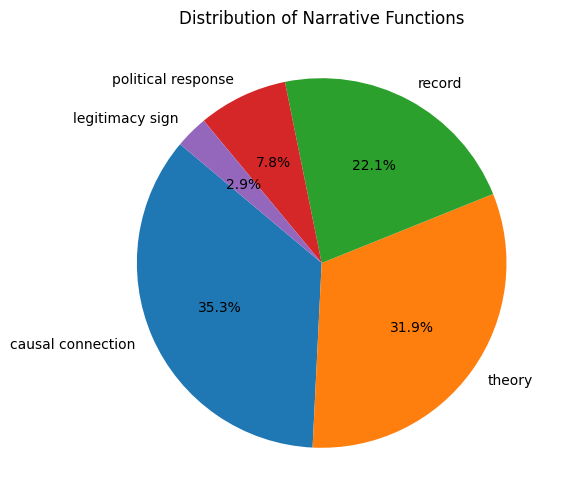

In [ ]:
label_counts = df["narrative_function"].value_counts()

# Create a pie chart
plt.figure(figsize=(6,6))
label_counts.plot(
    kind="pie",
    autopct="%1.1f%%",  # show percentages
    startangle=140      # rotate the start angle for aesthetics
)

plt.title("Distribution of Narrative Functions")
plt.ylabel("")  # Hide the y-axis label for a cleaner look
plt.show()

In [ ]:
df.isnull().sum() # check if there's NaN


,0
filename,0
omen,0
narrative_function,0


In [ ]:
# split into train, dev and test
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(
    df,
    test_size=0.3,
    random_state=42,
    stratify=df["narrative_function"]
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    random_state=42,
    stratify=temp_df["narrative_function"]
)


In [ ]:
print("Train label counts:")
print(train_df["narrative_function"].value_counts())
print()

print("Validation label counts:")
print(val_df["narrative_function"].value_counts())
print()

print("Test label counts:")
print(test_df["narrative_function"].value_counts())

Train label counts:
narrative_function
causal connection     215
theory                194
record                134
political response     48
legitimacy sign        17
Name: count, dtype: int64

Validation label counts:
narrative_function
causal connection     46
theory                41
record                29
political response    10
legitimacy sign        4
Name: count, dtype: int64

Test label counts:
narrative_function
causal connection     46
theory                42
record                29
political response    10
legitimacy sign        4
Name: count, dtype: int64


In [ ]:
train_df.to_csv("/content/drive/MyDrive/Colab Notebooks/omen_data_split/train.csv", index=False)
val_df.to_csv("/content/drive/MyDrive/Colab Notebooks/omen_data_split/val.csv", index=False)
test_df.to_csv("/content/drive/MyDrive/Colab Notebooks/omen_data_split/test.csv", index=False)